# CMIP6 Ocean Atlas

#### Functions to compare hydrographic observations to models

![](sections_qc.png)

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Functions we created

- `get_stats` : calculates statistics between model and GLODAP. Corr., STD, normalized-STD, bias.
- `TaylorDiagram` : class to make Taylor diagrams 
- `model_to_line` : interpolates model values to sample locations
- `glodap_to_model` : interpolates samples to model vertical grid
- `plot_section` :  plotting function for the sections

In [2]:
!pip install git+https://github.com/raphaeldussin/easy_coloc.git
from utils import model_to_line
from utils import glodap_to_model
from utils import gridder
from utils import get_stats
from utils import TaylorDiagram
from utils import plot_section
from utils import plot_taylor_diagram

  Cloning https://github.com/raphaeldussin/easy_coloc.git to /tmp/pip-req-build-wad2rp56
  Running command git clone -q https://github.com/raphaeldussin/easy_coloc.git /tmp/pip-req-build-wad2rp56
  Created wheel for easy-coloc: filename=easy_coloc-1.2-cp37-none-any.whl size=15236 sha256=7d5bd2345057eb4eb9d332f21f75610a9f9dbbd61f150932245bc0f2f65c3bb4
  Stored in directory: /tmp/pip-ephem-wheel-cache-riq9r1df/wheels/d2/7d/b4/b59fd9036952a1fd5fd53be0197d0765da76ff584b04961e7d
Successfully built easy-coloc


/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
expc = pd.read_csv(f'../qc/FILTERED_GLODAP_EXPOCODE.csv')
coords = pd.read_csv('../qc/GLODAPv2.2019_COORDS.csv')
glodap = pd.read_csv('../qc/GLODAPv2.2019_Merged_Master_File.csv')

# Check to see if a WOCE/GO-SHIP cruise line is in the database

In [4]:
ovar_name = 'po4'
cruise_line = 'A05'

In [5]:
cruise_id = expc[expc.LINE.str.contains(cruise_line)]
cruise_id

,Unnamed: 0,ID,EXPOCODE,LINE
80,694,695,74DI20040404,A05
82,698,699,74DI20100106,A05
106,832,1109,74EQ20151206,A05


In [6]:
# Here we select the first cruise in the database that covers this line
# Make sure the year (indicated in EXPOCODE) is less than 2015 (the end of the historical period)
cruise_id = cruise_id['ID'].iloc[-2]
cruise_id

699

### Get the subset of models that have this variable

In [7]:
# get CMIP6 catalog from intake-esm
import intake
col = intake.open_esm_datastore('../catalogs/pangeo-cmip6.json')
cat = col.search(variable_id=ovar_name,
                 table_id='Omon',
                 experiment_id='historical',
                 grid_label='gn')

# models that have this particular ocean variable
model_series = cat.df.drop_duplicates(subset='source_id')['source_id']
model_list = model_series.to_list()

# Plot our Section

## Position

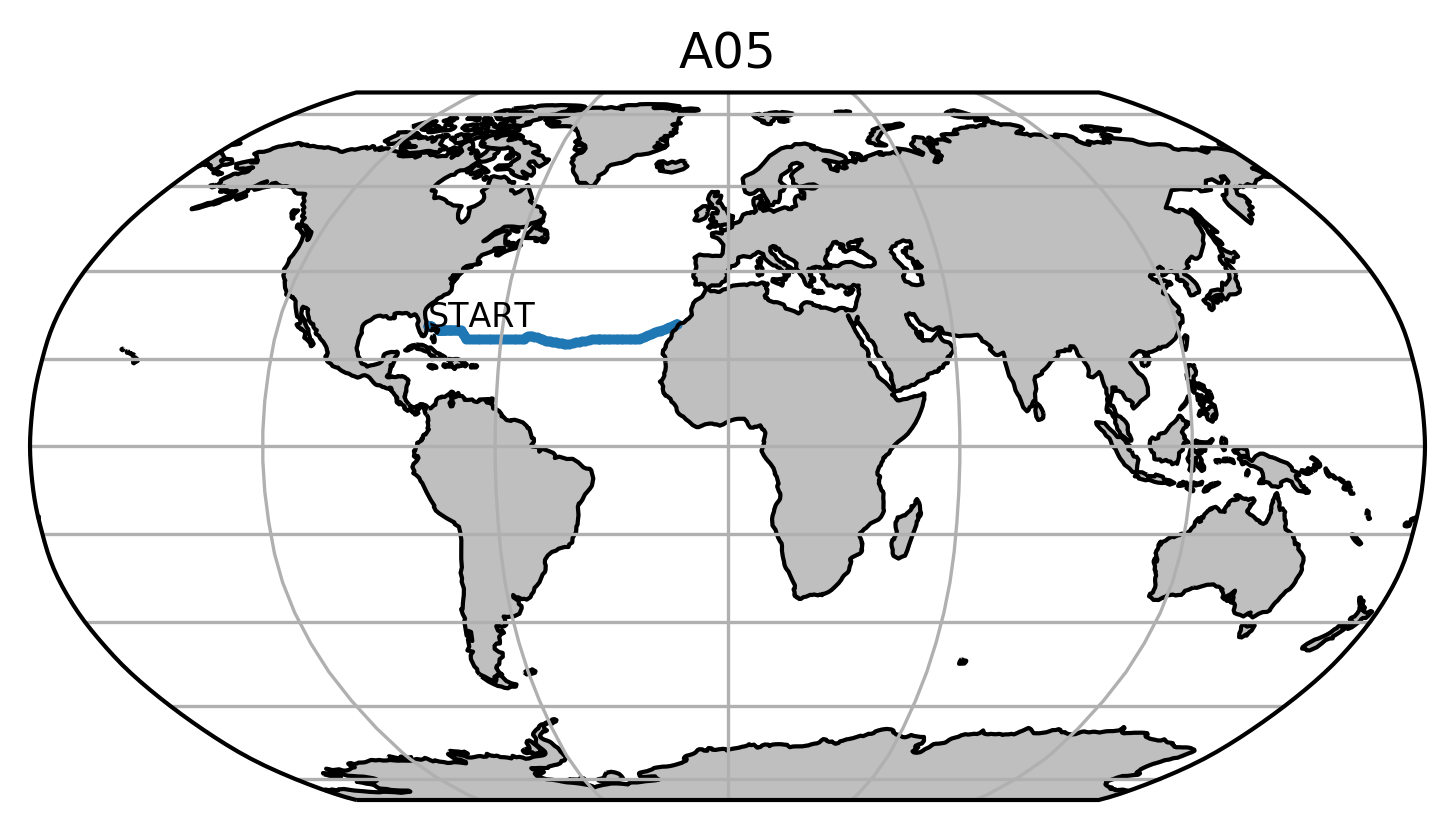

In [8]:
import cartopy as cart

lon = coords[coords.cruise==cruise_id].longitude
lat = coords[coords.cruise==cruise_id].latitude

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=cart.crs.Robinson())

ax.set_title(cruise_line)
ax.set_global()
C = ax.scatter(lon,lat, transform=cart.crs.PlateCarree(),s=2)

plt.text(lon.values[0], lat.values[0],'START',
             transform = cart.crs.PlateCarree(),
             fontsize=8)

ax.add_feature(cart.feature.LAND, facecolor='0.75')
ax.coastlines()
gl = ax.gridlines()

# Zoom

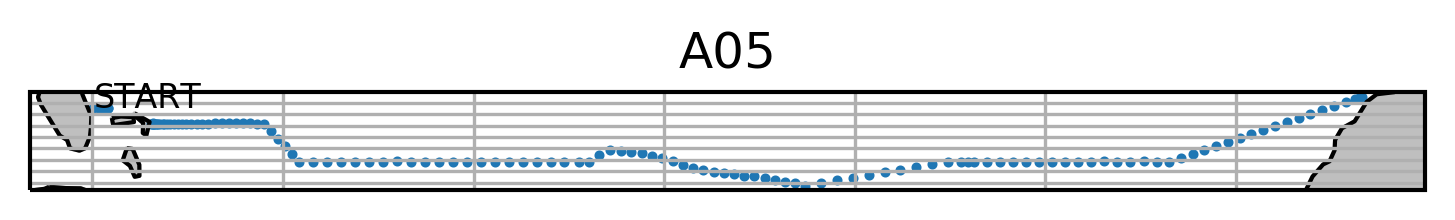

In [9]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=cart.crs.PlateCarree())

ax.set_title(cruise_line)
C = ax.scatter(lon,lat, transform=cart.crs.PlateCarree(),s=2)

plt.text(lon.values[0], lat.values[0],'START',
             transform = cart.crs.PlateCarree(),
             fontsize=8)

ax.add_feature(cart.feature.LAND, facecolor='0.75')
ax.coastlines()
gl = ax.gridlines()

# Calculate Stats

In [10]:
%%capture

samples = []

model_color = {'BCC-CSM2-MR':'pink',
               'BCC-ESM1':'hotpink',
               'CAMS-CSM1-0':'cadetblue',
               'FGOALS-f3-L':'gold',
               'CanESM5':'darksalmon',
               'MIROC-ES2L':'yellowgreen',
               'MIROC6':'darkolivegreen',
               'HadGEM3-GC31-LL':'darkorange',
               'UKESM1-0-LL':'sandybrown',
               'GISS-E2-1-G-CC':'k',
               #'GISS-E2-1-G':'slategray',
               'GFDL-ESM4':'rebeccapurple',
               'SAM0-UNICON':'lightseagreen',
               'MCM-UA-1-0':'mediumblue',
               #'NorCPM1':'violet', 
               'CESM2':'k',
              }

for model in model_color.keys():
    
    if model in model_list:
   
        ds_model = model_to_line(ovar_name=ovar_name,
                        model=model,
                        cruise_id=cruise_id,
                        write = True,
                        catalog_path='../../catalogs/pangeo-cmip6.json',
                        qc_path='../qc',
                        output_path='../../sections')

        ds_obs = glodap_to_model(cruise_id,glodap,coords,expc,ovar_name,model,output_path='../../sections')

        # input dictionary
        input_dict = {'model': model,
                       'ovar': ovar_name,
                       'ds_obs' : ds_obs,
                       'ds_mod' : ds_model}

        # get dictionary of statistics 
        stats_dict = get_stats(dict_params=input_dict)
        model_stats = [stats_dict['std_norm'], stats_dict['corr'],  stats_dict['model'], model_color[model]]

        samples.append(model_stats)

In [11]:
samples

[[0.0008538709400315812, 0.9724803764510289, 'MIROC-ES2L', 'yellowgreen'],
 [0.0008896094352886894, 0.8597438086402936, 'UKESM1-0-LL', 'sandybrown'],
 [0.00021582455498654697, 0.2242394196775956, 'CESM2', 'k']]

# Generate Taylor diagram

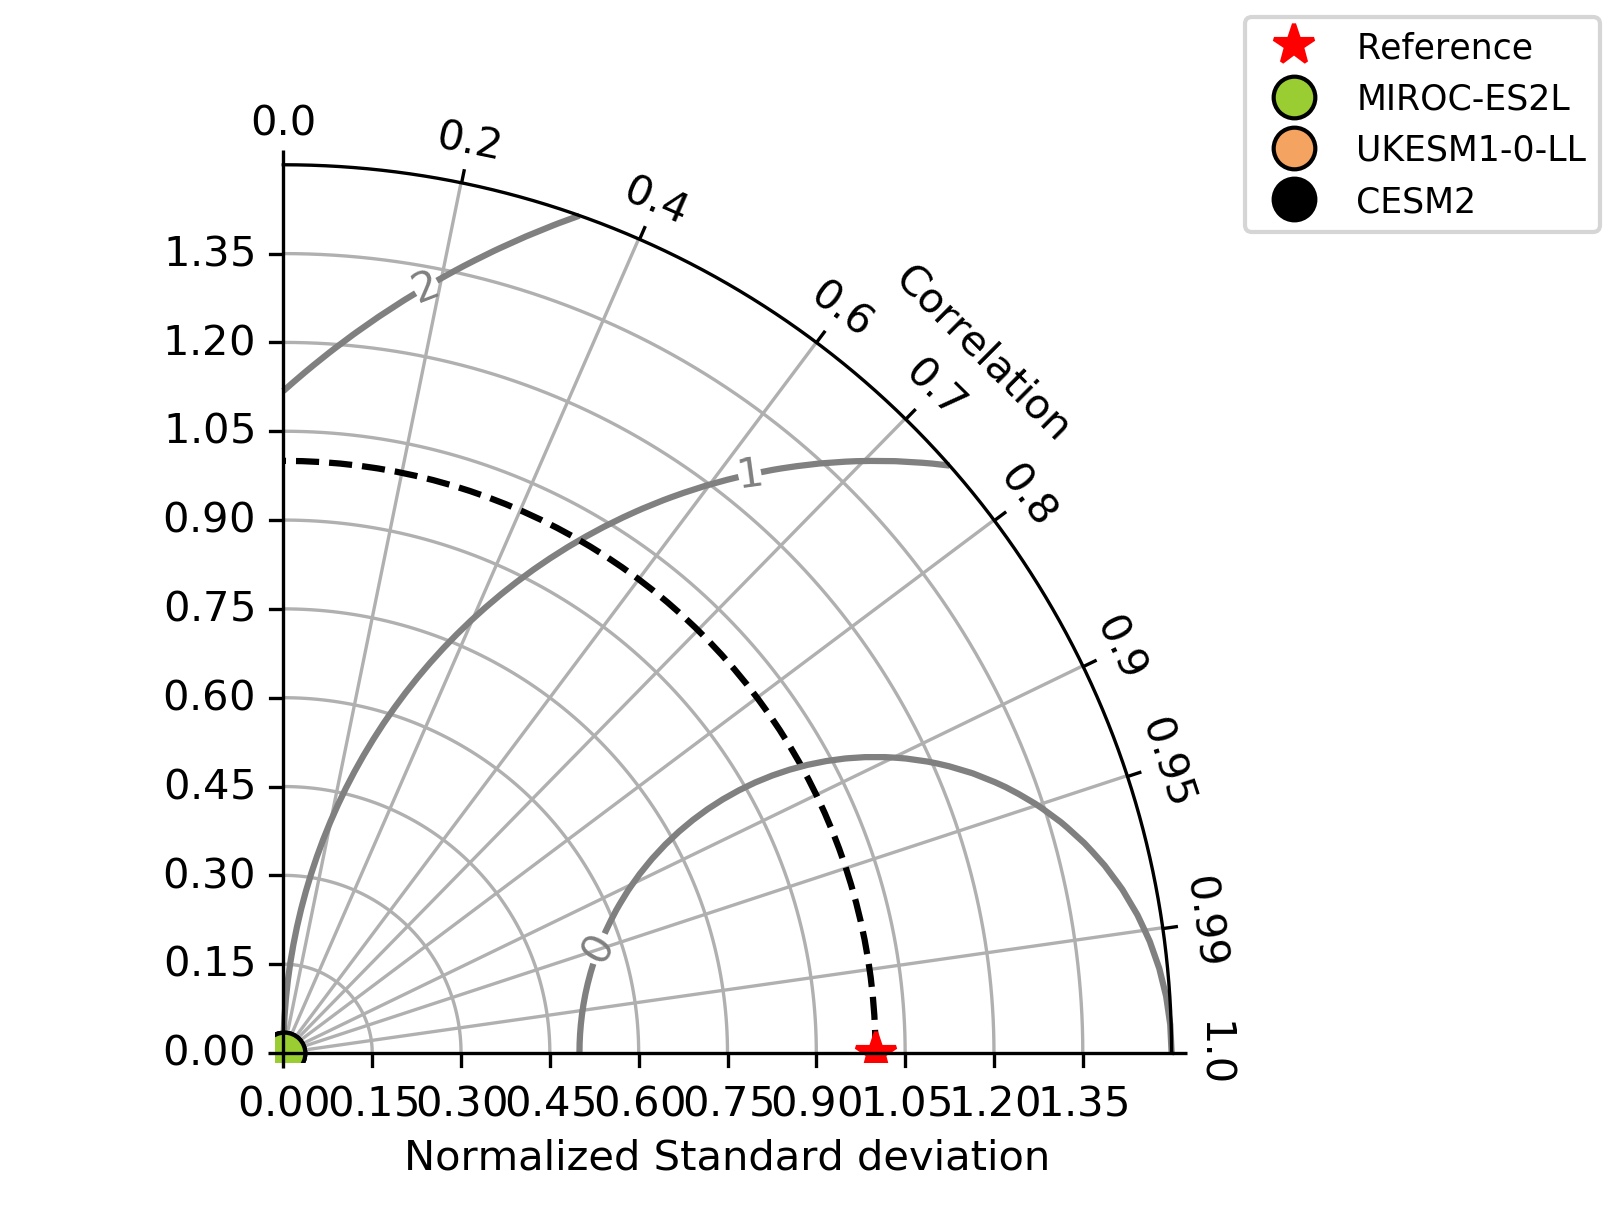

In [12]:
plot_taylor_diagram(samples,ref_std = 1,ref_color = 'r',ref_label = 'Reference')

# Compare a single model to observations

In [16]:
%%capture

model = 'MIROC-ES2L'

ds_model = model_to_line(ovar_name=ovar_name,
                model=model,
                cruise_id=cruise_id,
                catalog_path='../../catalogs/pangeo-cmip6.json',
                qc_path='../qc',
                output_path='../../sections')

# ds_model['lev'] = ds_model['lev']*1e-2

ds_obs = glodap_to_model(cruise_id,glodap,coords,expc,ovar_name,model,output_path='../../sections')

# Observations

In [17]:
import cmocean

(<Figure size 750x1200 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f73da83f2e8>)

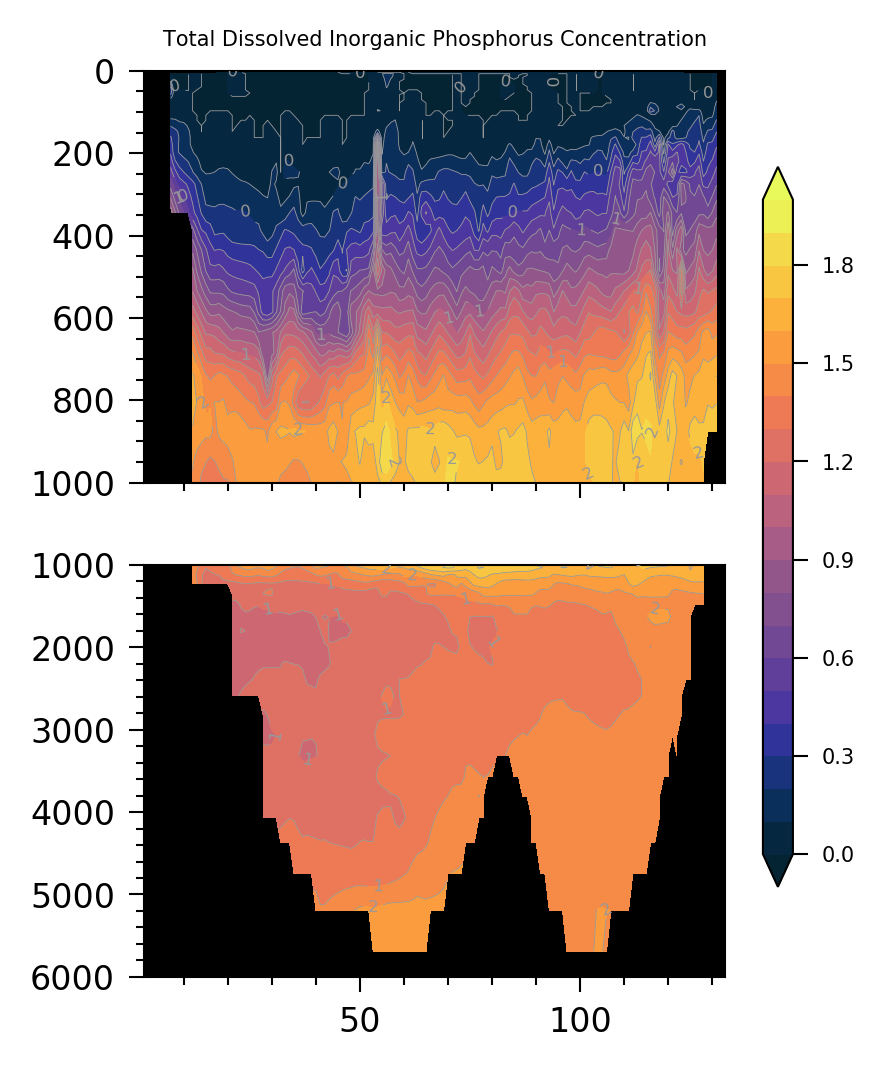

In [21]:
# plot_section(ds_obs[ovar_name],  cprops= {'thetao':(1,20,cmocean.cm.thermal,19,100,1e3)})
plot_section(ds_obs[ovar_name],  cprops= {'po4':(0,2,cmocean.cm.thermal,20,100,1e3)})

# Model

AttributeError: 'DataArray' object has no attribute 'long_name'

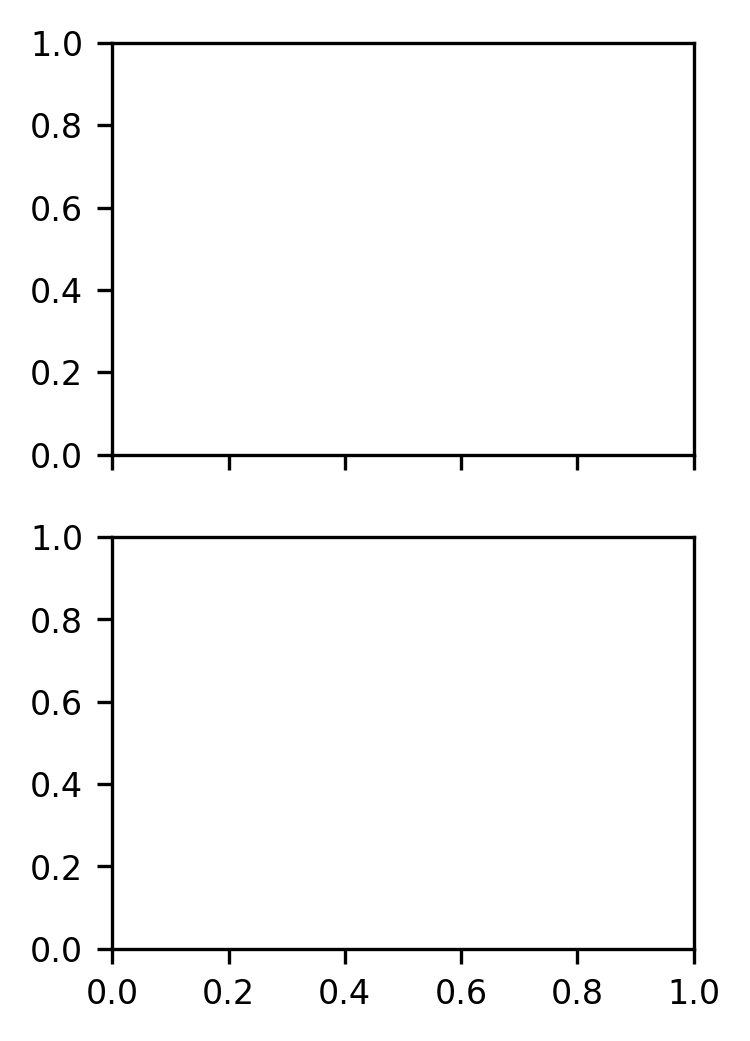

In [25]:
# plot_section(ds_obs[ovar_name],  cprops= {'thetao':(1,20,cmocean.cm.thermal,19,100,1e3)})
plot_section(ds_model[ovar_name],  cprops= {'po4':(0,2,cmocean.cm.thermal,10,100,1e3)})

# Model-Data difference

In [ ]:
ds_model['station'] = ds_obs['station']

delta = ds_model[ovar_name]-ds_obs[ovar_name]
delta.attrs['long_name'] = 'Pot. Temp. Difference'
plot_section(delta,cprops= {'thetao':(-10,10,cmocean.cm.balance,20,100,1e3)})

# Issues
- Some sections don't interpolate correctly; interpolation of observations needs to be improved
- Address different model coordinates names and units
- Improve perfomance of interpolation of one realization
